In [2]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import minimize, LinearConstraint

from flightmech.aircraft import Aircraft, Aerodynamics, AircraftState
from flightmech.propulsion import Propeller
from flightmech.propulsion import PropulsionSystem

#@formatter:off
%reload_ext autoreload
#@formatter:on

prop = Propeller(d=2, zeta=0.7, P_max=50e3, n_v=-1)
propulsion = PropulsionSystem(propulsor=prop, n_prop=2)

polar = 'naca_2315'


def load_aerodynamics(polar):
    df = pd.read_csv(f"../data/polare/{polar}.csv",
                     delimiter=",",
                     header=0,
                     names=['alpha', 'Re', 'Cl', 'Cd', 'Cm 0.25', 'TU', 'TL', 'SU', 'SL', 'L/D', 'A.C.', 'C.P.'],
                     dtype={'alpha': np.float64, 'Cl': np.float64, 'Cd': np.float64}
                     )

    k, k_1, C_W0 = np.polyfit(x=df['Cl'], y=df['Cd'], deg=2)

    df['polare'] = C_W0 + k_1 * df['Cl'] + k * df['Cl'] ** 2
    auftrieb_koeff = np.polyfit(x=df['alpha'], y=df['Cl'], deg=1)
    C_A_0, C_A_alpha = auftrieb_koeff

    return Aerodynamics(
        C_A_0=C_A_0,
        C_A_alpha=C_A_alpha,
        C_W0=C_W0,
        k=k,
        k_1=k_1
    )


ac = Aircraft(
    S=197,
    b=65,
    propulsion=propulsion,
    aerodynamics=load_aerodynamics('naca_2315'),
    m=2500
)

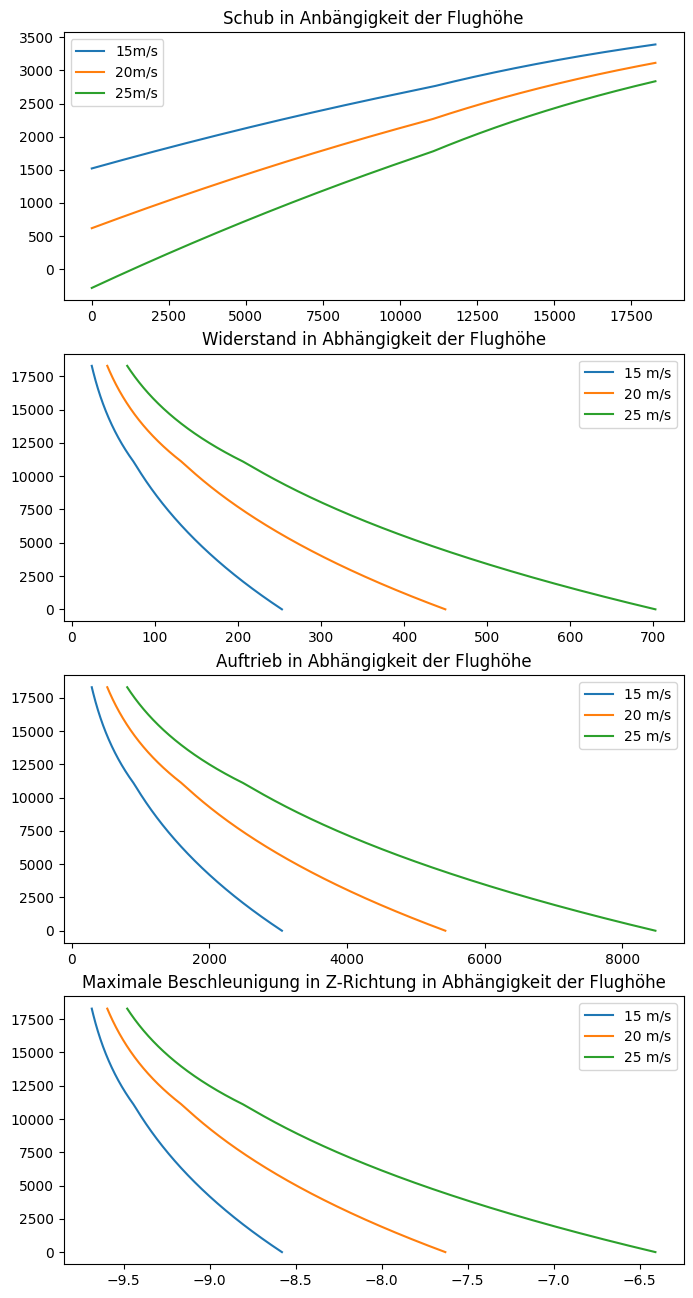

In [3]:
#@formatter:off
%autoreload 2
#@formatter:on

# Plot some curves to validate equations
h_range = np.arange(0, 18300, 10)
V_range = np.arange(15, 30, 5)

fig, ax = plt.subplots(4, figsize=(8, 16))
ax = ax.flatten()

ax[0].set_title("Schub in Anbängigkeit der Flughöhe")
for V in V_range:
    y = [ac.propulsion.thrust(h, V) for h in h_range]
    x = h_range
    ax[0].plot(x, y, label=f'{V}m/s')

ax[0].legend()


def update_ac_h(aircraft, h):
    aircraft.state.s[2] = -h
    return aircraft


ax[1].set_title("Widerstand in Abhängigkeit der Flughöhe")
for V in V_range:
    ac.state.V[0] = V
    x = h_range
    y = [update_ac_h(ac, h).W() for h in h_range]
    ax[1].plot(y, x, label=f'{V} m/s')

ax[1].legend()

ax[2].set_title("Auftrieb in Abhängigkeit der Flughöhe")
for V in V_range:
    ac.state.V[0] = V
    x = h_range
    y = [update_ac_h(ac, h).A() for h in h_range]
    ax[2].plot(y, x, label=f'{V} m/s')
    ax[2].legend()

ax[3].set_title("Maximale Beschleunigung in Z-Richtung in Abhängigkeit der Flughöhe")
for V in V_range:
    ac.state.V[0] = V
    x = h_range
    y = [-update_ac_h(ac, h).accel(1)[2] for h in h_range]
    ax[3].plot(y, x, label=f'{V} m/s')
ax[3].legend()

In [29]:
# Optimization for cruise
V = np.array([20, 0, 0])

alpha_0 = np.radians(7)
theta_0 = np.radians(7)
u_g_0 = 43
w_g_0 = 0
P_max_0 = 60e3
d_rotor = 3

init_state = AircraftState(
    alpha=alpha_0,
    theta=theta_0,
    gamma=0,
    V=np.array([20, 0, 0]),
    a=np.array([0, 0, 0]),
    s=np.array([0, 0, -18300])
)

polar = 'naca_2315_flaps_5'

ac.aerodynamics = load_aerodynamics(polar)

x0 = [alpha_0, theta_0, u_g_0, w_g_0, P_max_0, d_rotor]

ac.state = init_state

iters = []
i = 0

bounds = [(0, math.radians(12)), (0, math.radians(12)), (0, np.inf), (0, 0), (0, np.inf), (0, 6)]
constr = LinearConstraint([-1, 1, 0, 0, 0, 0], lb=0, ub=0)


def accel_z(x):
    global i
    # Modify angles
    ac.state.alpha = x[0]
    ac.state.theta = x[1]
    ac.state.gamma = ac.state.theta - ac.state.alpha
    # Modify speed
    ac.state.V = np.array([x[2], 0, x[3]])

    # Modify propeller characteristics
    ac.propulsion.propulsor.P_max = x[4]
    ac.propulsion.propulsor.d = x[5]

    accel = np.linalg.norm(ac.accel())
    iters.append(accel)
    i += 1
    return accel


res = minimize(accel_z, x0, method='trust-constr', bounds=bounds, constraints=constr)

print(f'success: {res.success}')
print(f'function result: {res.fun}')
print(f'alpha={math.degrees(res.x[0])}')
print(f'theta={math.degrees(res.x[1])}')
print(f'u_g={res.x[2]}')
print(f'w_g={res.x[3]}')
print(f'P_max={res.x[4]}')
print(f'd_rotor={res.x[5]}')

C:\Users\Aarango\AppData\Local\pypoetry\Cache\virtualenvs\flightmech-17NV4TQ_-py3.9\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


success: True
function result: 7.31188750898456e-08
alpha=10.916137380416743
theta=10.916137380416743
u_g=95.7521478114612
w_g=4.3870995959641677e-20
P_max=59996.8602653473
d_rotor=0.5456304039477481


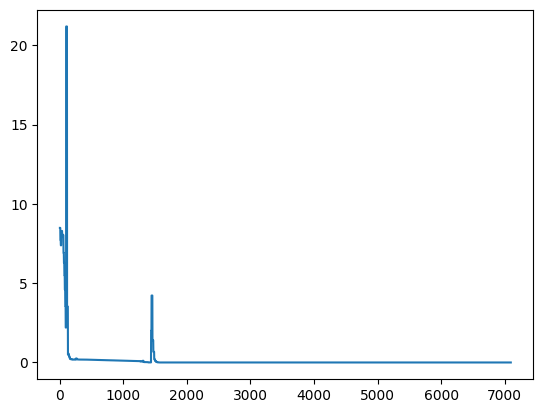

In [5]:
ax = plt.subplot()
ax.plot(np.arange(i), iters)